## FAANG Analysis and Price Forecasting using Time Series Models
(Facebook-Meta, Amazon, Apple, Netflix, Google)

#### DATA 690 Project
BY:
- Srinivas Naidu Pasyavula (QC61851)
- Varshita Adavi (OC83614)

In [1]:
# importing all the required libraries and packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import warnings
import yfinance as yf
import seaborn as sns; sns.set()
yf.pdr_override() 
%matplotlib inline
warnings.filterwarnings('ignore')
from fredapi import Fred
import statsmodels.api as sm
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# for modeling
from statsmodels.tsa.arima.model import ARIMA
#plt.rcParams["figure.figsize"] = (10,6)
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose # for time series components

### Import Data

In [2]:
# loading the data from yahoo finance
stocks = ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX', '^GSPC']
start = datetime.datetime(2022,1,1)
end = datetime.datetime(2023,1,1)
port = yf.download(stocks, start=start, end=end, interval='1d')['Close']

[*********************100%***********************]  6 of 6 completed


In [3]:
# displaying the head and tail of the dataset
print("The first five rows of the dataset:")
display(port.head())
print("\nThe last five rows of the dataset:")
display(port.tail())

The first five rows of the dataset:


,AAPL,AMZN,GOOGL,META,NFLX,^GSPC
Date,,,,,,
2022-01-03,182.009995,170.404495,144.991501,338.540009,597.369995,4796.560059
2022-01-04,179.699997,167.522003,144.399506,336.529999,591.150024,4793.540039
2022-01-05,174.919998,164.356995,137.774994,324.170013,567.520020,4700.580078
2022-01-06,172.000000,163.253998,137.747498,332.459991,553.289978,4696.049805
2022-01-07,172.169998,162.554001,137.016998,331.790009,541.059998,4677.029785



The last five rows of the dataset:


,AAPL,AMZN,GOOGL,META,NFLX,^GSPC
Date,,,,,,
2022-12-23,131.860001,85.250000,89.230003,118.040001,294.959991,3844.820068
2022-12-27,130.029999,83.040001,87.389999,116.879997,284.170013,3829.250000
2022-12-28,126.040001,81.820000,86.019997,115.620003,276.880005,3783.219971
2022-12-29,129.610001,84.180000,88.449997,120.260002,291.119995,3849.280029
2022-12-30,129.929993,84.000000,88.230003,120.339996,294.880005,3839.500000


### EDA and Data Pre-processing

In [4]:
# checking for the number of null values
port.isnull().sum()

AAPL     0
AMZN     0
GOOGL    0
META     0
NFLX     0
^GSPC    0
dtype: int64

In [5]:
# determing the statistics of the data
port.describe()

,AAPL,AMZN,GOOGL,META,NFLX,^GSPC
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,154.835060,126.098819,114.760371,180.187690,284.639244,4098.514748
std,13.056081,23.904315,16.109141,56.658923,94.541783,291.830195
min,126.040001,81.820000,83.430000,88.910004,166.369995,3577.030029
25%,144.645004,108.889500,100.879997,138.059998,217.285004,3861.135010
50%,154.089996,122.769997,113.891998,170.160004,249.300003,4027.260010
75%,165.915001,145.857506,129.215500,207.655006,353.154999,4338.870117
max,182.009995,170.404495,148.000000,338.540009,597.369995,4796.560059


In [6]:
port = port.rename({'^GSPC':'GSPC'}, axis='columns')
port.head()

,AAPL,AMZN,GOOGL,META,NFLX,GSPC
Date,,,,,,
2022-01-03,182.009995,170.404495,144.991501,338.540009,597.369995,4796.560059
2022-01-04,179.699997,167.522003,144.399506,336.529999,591.150024,4793.540039
2022-01-05,174.919998,164.356995,137.774994,324.170013,567.520020,4700.580078
2022-01-06,172.000000,163.253998,137.747498,332.459991,553.289978,4696.049805
2022-01-07,172.169998,162.554001,137.016998,331.790009,541.059998,4677.029785


In [7]:
# creating dataframe for the five companies excluding the market index
faang_port = port.iloc[: , :-1]
faang_port.head()

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2022-01-03,182.009995,170.404495,144.991501,338.540009,597.369995
2022-01-04,179.699997,167.522003,144.399506,336.529999,591.150024
2022-01-05,174.919998,164.356995,137.774994,324.170013,567.520020
2022-01-06,172.000000,163.253998,137.747498,332.459991,553.289978
2022-01-07,172.169998,162.554001,137.016998,331.790009,541.059998


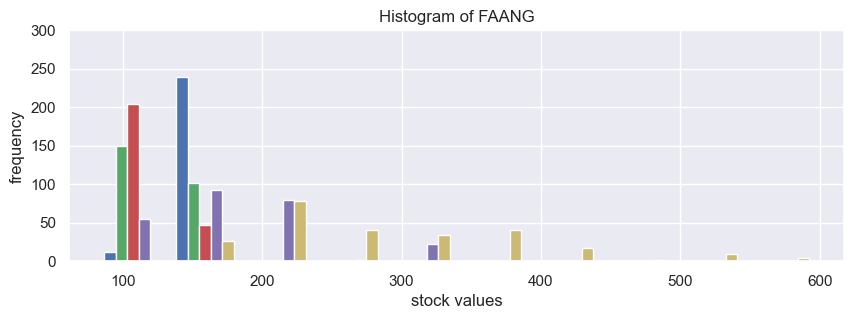

In [8]:
# graphical representation of the stock values and its frequency over the given time period
plt.figure(figsize=(10,3))
plt.hist(faang_port)
plt.title("Histogram of FAANG")
plt.xlabel('stock values')
plt.ylabel('frequency')
plt.ylim(0, 300)
plt.show()

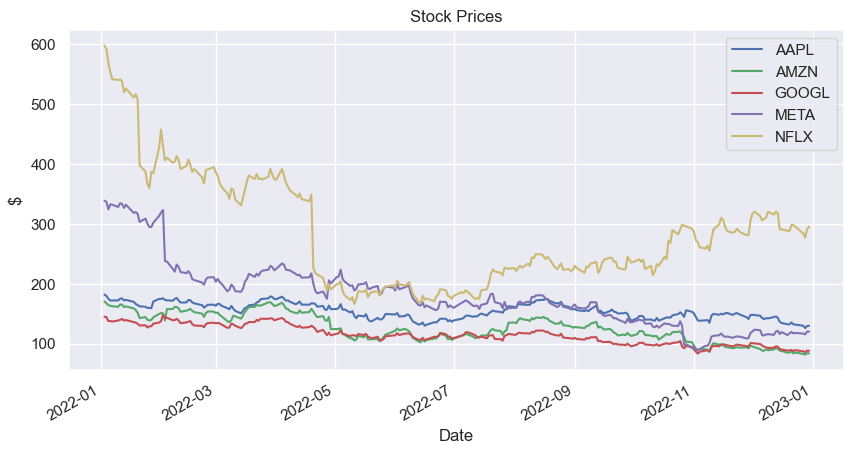

In [9]:
# illustrating the stocks in graphical representation
faang_port.plot(figsize=(10, 5))
plt.title('Stock Prices')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

### Correlation of the data

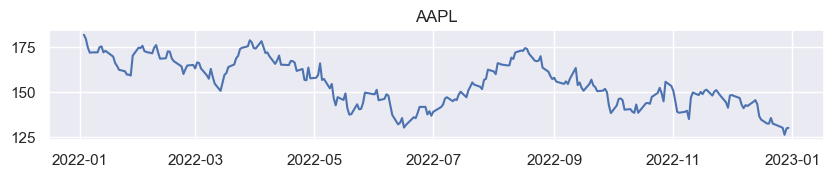

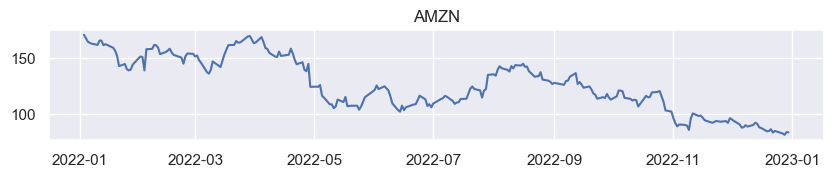

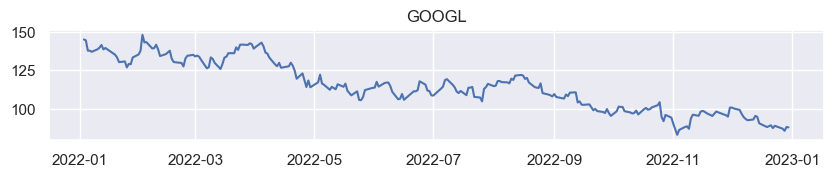

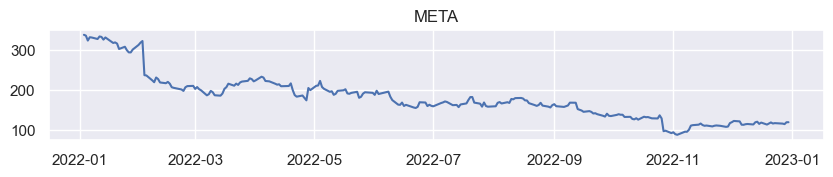

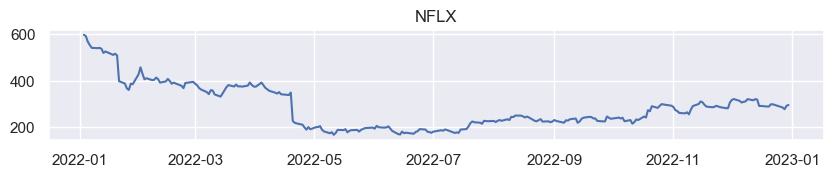

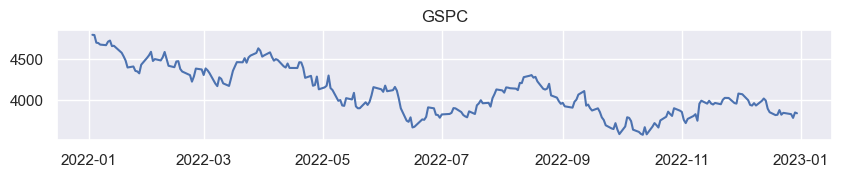

In [10]:
# examining the data through visualization and correlation
for i, stock in enumerate(port.columns, start=1):
    plt.figure(figsize=(10,10))
    plt.subplot(6, 1, i)
    plt.plot(port[stock])
    plt.title(f'{stock}')
    plt.show()

In [11]:
# correlation of faang companies
faang_port.corr()

,AAPL,AMZN,GOOGL,META,NFLX
AAPL,1.000000,0.896738,0.826182,0.686317,0.609289
AMZN,0.896738,1.000000,0.924019,0.781731,0.591063
GOOGL,0.826182,0.924019,1.000000,0.866665,0.591600
META,0.686317,0.781731,0.866665,1.000000,0.636582
NFLX,0.609289,0.591063,0.591600,0.636582,1.000000


<AxesSubplot:>

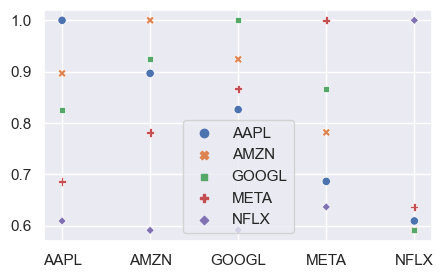

In [12]:
# plotting the correlation of faang
sns.set(rc={'figure.figsize':(5,3)})
sns.scatterplot(data=faang_port.corr())

In [13]:
# determing the correlation of entire dataset
port.corr()

,AAPL,AMZN,GOOGL,META,NFLX,GSPC
AAPL,1.000000,0.896738,0.826182,0.686317,0.609289,0.876508
AMZN,0.896738,1.000000,0.924019,0.781731,0.591063,0.845672
GOOGL,0.826182,0.924019,1.000000,0.866665,0.591600,0.889455
META,0.686317,0.781731,0.866665,1.000000,0.636582,0.820667
NFLX,0.609289,0.591063,0.591600,0.636582,1.000000,0.751133
GSPC,0.876508,0.845672,0.889455,0.820667,0.751133,1.000000


<AxesSubplot:>

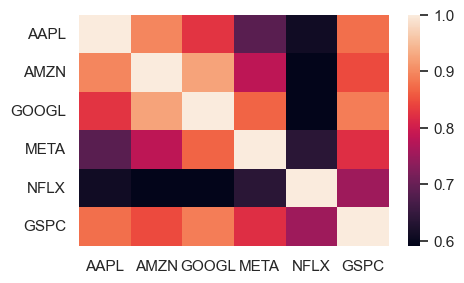

In [14]:
# plotting the correlation of faang and its market index S&P500
sns.heatmap(port.corr())

### Calculating Returns and Risk Free Factor

In [15]:
fred = Fred(api_key='0552dd6778c77aee01ca752e2578a16b') # my API key

In [16]:
fred.search('risk free')

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
DGS10,DGS10,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 10...,1962-01-02,2023-03-31,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2023-04-03 15:20:03-05:00,91,For further information regarding treasury con...
GS10,GS10,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 10...,1953-04-01,2023-03-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2023-04-03 15:17:07-05:00,71,Averages of business days. For further informa...
WGS10YR,WGS10YR,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 10...,1962-01-05,2023-03-24,"Weekly, Ending Friday",W,Percent,%,Not Seasonally Adjusted,NSA,2023-03-27 15:18:03-05:00,55,Averages of business days. For further informa...
DGS2,DGS2,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 2-...,1976-06-01,2023-03-30,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2023-03-31 15:22:03-05:00,82,For further information regarding treasury con...
GS2,GS2,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 2-...,1976-06-01,2023-03-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2023-04-03 15:17:16-05:00,44,Averages of business days. For further informa...
DGS1,DGS1,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 1-...,1962-01-02,2023-03-30,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2023-03-31 15:22:04-05:00,79,For further information regarding treasury con...
WGS2YR,WGS2YR,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 2-...,1976-06-04,2023-03-24,"Weekly, Ending Friday",W,Percent,%,Not Seasonally Adjusted,NSA,2023-03-27 15:18:06-05:00,34,Averages of business days. For further informa...
DGS5,DGS5,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 5-...,1962-01-02,2023-03-31,Daily,D,Percent,%,Not Seasonally Adjusted,NSA,2023-04-03 15:20:08-05:00,78,For further information regarding treasury con...
WGS1YR,WGS1YR,2023-04-03,2023-04-03,Market Yield on U.S. Treasury Securities at 1-...,1962-01-05,2023-03-24,"Weekly, Ending Friday",W,Percent,%,Not Seasonally Adjusted,NSA,2023-03-27 15:18:04-05:00,51,Averages of business days. For further informa...


In [17]:
risk_free = fred.get_series('DGS3MO')
risk_free = risk_free['2022-01-01':'2023-01-01']

In [18]:
# determing the risk free factor
risk_free

2022-01-03    0.08
2022-01-04    0.08
2022-01-05    0.09
2022-01-06    0.10
2022-01-07    0.10
              ... 
2022-12-26     NaN
2022-12-27    4.46
2022-12-28    4.46
2022-12-29    4.45
2022-12-30    4.42
Length: 260, dtype: float64

In [19]:
# determining the returns of the data
returns = port.pct_change()
returns.dropna(inplace=True)
returns.head()

,AAPL,AMZN,GOOGL,META,NFLX,GSPC
Date,,,,,,
2022-01-04,-0.012692,-0.016916,-0.004083,-0.005937,-0.010412,-0.000630
2022-01-05,-0.026600,-0.018893,-0.045876,-0.036728,-0.039973,-0.019393
2022-01-06,-0.016693,-0.006711,-0.000200,0.025573,-0.025074,-0.000964
2022-01-07,0.000988,-0.004288,-0.005303,-0.002015,-0.022104,-0.004050
2022-01-10,0.000116,-0.006570,0.012061,-0.011212,-0.002236,-0.001441


In [20]:
# converting 1 year risk free rate to daily risk free rate.
risk_free = risk_free/365

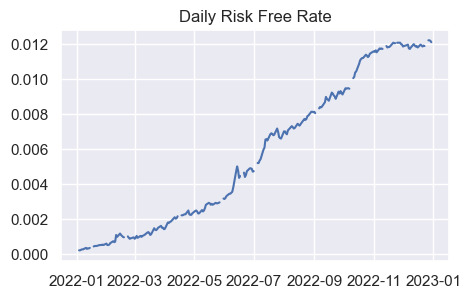

In [21]:
# illustrating the daily risk free rate.
plt.plot(risk_free)
plt.title('Daily Risk Free Rate')
plt.show()

In [22]:
# calculating the stock values with excess return factor
stocks = port.columns
for i in stocks:
    returns[f"excess_return_{i}"] = returns[i] - risk_free

In [23]:
returns.head()

,AAPL,AMZN,GOOGL,META,NFLX,GSPC,excess_return_AAPL,excess_return_AMZN,excess_return_GOOGL,excess_return_META,excess_return_NFLX,excess_return_GSPC
Date,,,,,,,,,,,,
2022-01-04,-0.012692,-0.016916,-0.004083,-0.005937,-0.010412,-0.000630,-0.012911,-0.017135,-0.004302,-0.006156,-0.010631,-0.000849
2022-01-05,-0.026600,-0.018893,-0.045876,-0.036728,-0.039973,-0.019393,-0.026846,-0.019140,-0.046123,-0.036974,-0.040220,-0.019639
2022-01-06,-0.016693,-0.006711,-0.000200,0.025573,-0.025074,-0.000964,-0.016967,-0.006985,-0.000474,0.025299,-0.025348,-0.001238
2022-01-07,0.000988,-0.004288,-0.005303,-0.002015,-0.022104,-0.004050,0.000714,-0.004562,-0.005577,-0.002289,-0.022378,-0.004324
2022-01-10,0.000116,-0.006570,0.012061,-0.011212,-0.002236,-0.001441,-0.000240,-0.006926,0.011704,-0.011568,-0.002593,-0.001797


In [24]:
# dropping the null values present in returns dataframe
returns.dropna(inplace= True)

### Capital Asset Pricing Model

APPLE

In [25]:
# for Apple
y_aapl = returns['excess_return_AAPL']
X = returns['excess_return_GSPC']

In [26]:
X = sm.add_constant(X, prepend=False)
capm_aapl = sm.OLS(y_aapl, X)# Ordinary Least Square (OLS)
capm_result_aapl = capm_aapl.fit()

In [27]:
capm_result_aapl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_AAPL   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     952.9
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           1.41e-86
Time:                        16:27:43   Log-Likelihood:                 781.46
No. Observations:                 248   AIC:                            -1559.
Df Residuals:                     246   BIC:                            -1552.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.3043      0.042     30.869      0.000       1.221       1.388
const                  0.0016      0.001      2.207      0.028       0.000       0.003
==============================================================================
Omnibus:                       21.437   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.419
Skew:                           0.266   Prob(JB):                     1.03e-14
Kurtosis:                       5.439   Cond. No.                         64.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
capm_result_aapl.params[0]

1.3043272751390056

AMAZON

In [29]:
# for Amazon
y_amzn = returns['excess_return_AMZN']
X = returns['excess_return_GSPC']

In [30]:
X = sm.add_constant(X, prepend=False)
capm_amzn = sm.OLS(y_amzn, X)# Ordinary Least Square (OLS)
capm_result_amzn = capm_amzn.fit()

In [31]:
capm_result_amzn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_AMZN   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     437.0
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           1.80e-56
Time:                        16:27:43   Log-Likelihood:                 629.23
No. Observations:                 248   AIC:                            -1254.
Df Residuals:                     246   BIC:                            -1247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.6319      0.078     20.904      0.000       1.478       1.786
const                  0.0024      0.001      1.829      0.069      -0.000       0.005
==============================================================================
Omnibus:                       74.007   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1517.100
Skew:                           0.563   Prob(JB):                         0.00
Kurtosis:                      15.064   Cond. No.                         64.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
capm_result_amzn.params[0]

1.6318676812191613

GOOGLE

In [33]:
# for Google
y_googl = returns['excess_return_GOOGL']
X = returns['excess_return_GSPC']

In [34]:
X = sm.add_constant(X, prepend=False)
capm_googl = sm.OLS(y_googl, X)# Ordinary Least Square (OLS)
capm_result_googl = capm_googl.fit()

In [35]:
capm_result_googl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     excess_return_GOOGL   R-squared:                       0.717
Model:                             OLS   Adj. R-squared:                  0.716
Method:                  Least Squares   F-statistic:                     622.4
Date:                 Mon, 03 Apr 2023   Prob (F-statistic):           2.53e-69
Time:                         16:27:43   Log-Likelihood:                 721.64
No. Observations:                  248   AIC:                            -1439.
Df Residuals:                      246   BIC:                            -1432.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.3416      0.054     24.947      0.000       1.236       1.448
const                  0.0012      0.001      1.362      0.174      -0.001       0.003
==============================================================================
Omnibus:                       58.716   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.774
Skew:                          -0.615   Prob(JB):                    4.49e-112
Kurtosis:                       9.936   Cond. No.                         64.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
capm_result_googl.params[0]

1.3416295480789862

FACEBOOK

In [37]:
# for Facebook
y_meta = returns['excess_return_META']
X = returns['excess_return_GSPC']

In [38]:
X = sm.add_constant(X, prepend=False)
capm_meta = sm.OLS(y_meta, X)# Ordinary Least Square (OLS)
capm_result_meta = capm_meta.fit()

In [39]:
capm_result_meta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_META   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     181.1
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           2.66e-31
Time:                        16:27:44   Log-Likelihood:                 510.66
No. Observations:                 248   AIC:                            -1017.
Df Residuals:                     246   BIC:                            -1010.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.6943      0.126     13.456      0.000       1.446       1.942
const                  0.0020      0.002      0.926      0.355      -0.002       0.006
==============================================================================
Omnibus:                      203.122   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5935.385
Skew:                          -2.910   Prob(JB):                         0.00
Kurtosis:                      26.249   Cond. No.                         64.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
capm_result_meta.params[0]

1.694315108539906

NETFLIX

In [41]:
# for Netflix
y_nflx = returns['excess_return_NFLX']
X = returns['excess_return_GSPC']

In [42]:
X = sm.add_constant(X, prepend=False)
capm_nflx = sm.OLS(y_nflx, X)# Ordinary Least Square (OLS)
capm_result_nflx = capm_nflx.fit()

In [43]:
capm_result_nflx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     excess_return_NFLX   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     107.5
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           3.89e-21
Time:                        16:27:44   Log-Likelihood:                 468.78
No. Observations:                 248   AIC:                            -933.6
Df Residuals:                     246   BIC:                            -926.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
excess_return_GSPC     1.5459      0.149     10.369      0.000       1.252       1.840
const                  0.0023      0.003      0.894      0.372      -0.003       0.007
==============================================================================
Omnibus:                      249.239   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14121.644
Skew:                          -3.743   Prob(JB):                         0.00
Kurtosis:                      39.202   Cond. No.                         64.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
capm_result_nflx.params[0]

1.5458649251304881

#### Interpretation:
- If the beta value is less than 1, it indicates that the asset returns are less volatile than the market.
- The intercept determines the expected excess return of an asset when the market return is zero.

### Security Market Line

In [45]:
# defining the security market line (sml)
def SML(rf, betas, ret):
    asset_ret = [rf + (rm-rf)*i for i in betas]
    plt.figure(figsize=(5,3))
    plt.plot(betas, asset_ret)
    plt.xlabel('Asset Beta')
    plt.ylabel('Asset Return')
    plt.title('Security Market Line')
    plt.plot(1, ret, 'ro')

In [46]:
betas = [capm_result_aapl.params[0],capm_result_amzn.params[0],capm_result_googl.params[0],capm_result_meta.params[0],capm_result_nflx.params[0]]
rm = returns['GSPC'].mean()
risk_free_rate = risk_free.mean()

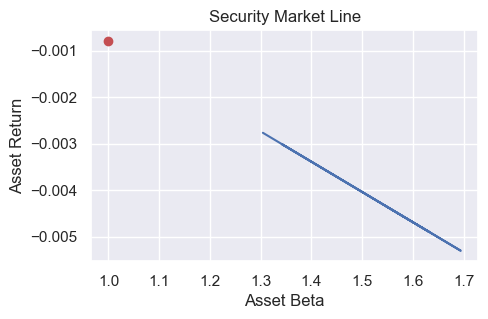

In [47]:
SML(risk_free_rate, betas, rm)

In [48]:
# Assume the return expectation for apple is 8%, amazon is 9%, google is 0.5%, facebook is 0.7% and netflix is 3%
ret_exp = [0.08, 0.09, 0.005, 0.007, 0.03]
df_ret_exp = pd.DataFrame(ret_exp)
df_betas = pd.DataFrame(betas)
df_all = pd.concat([df_betas, df_ret_exp], axis=1)
df_all.columns = ['betas', 'ret_exp']
df_all.index = returns.columns[:5]

In [49]:
df_all

,betas,ret_exp
AAPL,1.304327,0.080
AMZN,1.631868,0.090
GOOGL,1.341630,0.005
META,1.694315,0.007
NFLX,1.545865,0.030


In [50]:
# function to estimate whether the stock price is over valued or under valued
def over_valued(rf, rm, stock):
    x = rf + (rm - rf)*df_all['betas'].loc[stock]
    y = df_all['ret_exp'].loc[stock]
    if x < y:
        print('The stock is undervalued')
    elif x > y:
        print('The stock is overvalued')
    else:
        print('The stock is fairly priced')

In [51]:
over_valued(risk_free_rate, rm, 'AAPL')

The stock is undervalued


In [52]:
over_valued(risk_free_rate, rm, 'AMZN')

The stock is undervalued


In [53]:
over_valued(risk_free_rate, rm, 'GOOGL')

The stock is undervalued


In [54]:
over_valued(risk_free_rate, rm, 'META')

The stock is undervalued


In [55]:
over_valued(risk_free_rate, rm, 'NFLX')

The stock is undervalued


### Sharpe ratio and Treynor ratio

In [56]:
# calculating the sharpe ratio
def sharpe(stocks, rf, n_assets):
    sharpe_ratios = {}
    for i ,j in zip(stocks, range(n_assets)):
        sharpe_ratios[i] = round((returns.iloc[:, j].mean() - rf)/np.std(returns.iloc[:,j]), 4)
    return sharpe_ratios

In [57]:
# calculating the treynor ratio
def treynor(stocks, rf, n_assets): 
    treynor_ratios = {}
    for i, stock in enumerate(stocks):
        treynor_ratios[stock] = round((returns.iloc[:, i].mean() - rf) / df_all['betas'][stock], 4)
    return treynor_ratios

In [58]:
# determing the sharpe values
n_assets = 5
sharpe_ratios = sharpe(stocks, risk_free_rate, n_assets)
sharpe_ratios

{'AAPL': -0.3072,
 'AMZN': -0.2604,
 'GOOGL': -0.3072,
 'META': -0.2229,
 'NFLX': -0.1768}

In [59]:
treynor_stocks = returns.columns[:2]

In [60]:
# determing the treynor values
treynor_ratios = treynor(treynor_stocks, risk_free_rate, n_assets)
treynor_ratios

{'AAPL': -0.0053, 'AMZN': -0.005}

In [61]:
print(max(sharpe_ratios, key=sharpe_ratios.get)) 
print(max(sharpe_ratios.values()))

NFLX
-0.1768


In [62]:
print(min(sharpe_ratios, key=sharpe_ratios.get)) 
print(min(sharpe_ratios.values()))

AAPL
-0.3072


In [63]:
print(max(treynor_ratios, key=treynor_ratios.get)) 
print(max(treynor_ratios.values()))

AMZN
-0.005


In [64]:
print(min(treynor_ratios, key=treynor_ratios.get)) 
print(min(treynor_ratios.values()))

AAPL
-0.0053


#### Interpretation:
- According to Sharpe Ratio: lowest Sharpe ratio indicating that it assumes higher risk per return in relative to other stocks considered.
- According to Treynor ratio: higher Treynor ratio is typically seen as better than a lower one.

### Portfolio of FAANG

In [65]:
# returns1 is indicated for the faang companies
returns1 = faang_port.pct_change()
returns1.dropna(inplace=True)
returns1.head()

,AAPL,AMZN,GOOGL,META,NFLX
Date,,,,,
2022-01-04,-0.012692,-0.016916,-0.004083,-0.005937,-0.010412
2022-01-05,-0.026600,-0.018893,-0.045876,-0.036728,-0.039973
2022-01-06,-0.016693,-0.006711,-0.000200,0.025573,-0.025074
2022-01-07,0.000988,-0.004288,-0.005303,-0.002015,-0.022104
2022-01-10,0.000116,-0.006570,0.012061,-0.011212,-0.002236


In [66]:
# annualized returns
returns1.mean()

AAPL    -0.001097
AMZN    -0.002329
GOOGL   -0.001689
META    -0.003262
NFLX    -0.001760
dtype: float64

In [67]:
# annualized covariance
returns1.cov() * np.sqrt(252)

,AAPL,AMZN,GOOGL,META,NFLX
AAPL,0.008016,0.007826,0.006943,0.008578,0.007894
AMZN,0.007826,0.015823,0.008830,0.012313,0.012875
GOOGL,0.006943,0.008830,0.009448,0.010679,0.008699
META,0.008578,0.012313,0.010679,0.026109,0.016181
NFLX,0.007894,0.012875,0.008699,0.016181,0.031044


In [68]:
# assuming risk_free_rate as 0.05
risk_free_rate = 0.05

In [69]:
# Calculate the annualized return and standard deviation for each stock
# number of stock exchange days in a year are 252
annualized_return = returns1.mean() * 252
annualized_std = returns1.std() * np.sqrt(252)

In [70]:
# Calculate the Sharpe ratio for each stock
stock_sharpe = (annualized_return - risk_free_rate) / annualized_std

In [71]:
print("Annualized Return:\n", annualized_return)
print("\nAnnualized Standard Deviation:\n", annualized_std)
print("\nStock Sharpe Ratio:\n", stock_sharpe)

Annualized Return:
 AAPL    -0.276351
AMZN    -0.586943
GOOGL   -0.425538
META    -0.822084
NFLX    -0.443465
dtype: float64

Annualized Standard Deviation:
 AAPL     0.356716
AMZN     0.501177
GOOGL    0.387272
META     0.643788
NFLX     0.702004
dtype: float64

Stock Sharpe Ratio:
 AAPL    -0.914876
AMZN    -1.270893
GOOGL   -1.227916
META    -1.354613
NFLX    -0.702937
dtype: float64


In [72]:
# finding the covariance:
co_var = returns1.cov()*252
co_var

,AAPL,AMZN,GOOGL,META,NFLX
AAPL,0.127246,0.124233,0.110223,0.136171,0.125316
AMZN,0.124233,0.251178,0.140179,0.195457,0.204377
GOOGL,0.110223,0.140179,0.149980,0.169530,0.138098
META,0.136171,0.195457,0.169530,0.414463,0.256861
NFLX,0.125316,0.204377,0.138098,0.256861,0.492810


In [73]:
iterations = 30000   # more iterations better the value be 
def portfolio_frontier(iterations, stocks):
    portfolio_exp_means = []
    portfolio_std_devs = []
    all_weights = []
    for i in range(iterations):
        weights = np.random.random(len(stocks)-1)
        weights /= np.sum(weights)
        all_weights.append(weights)
        portfolio_exp_means.append(np.sum(returns1.mean()*weights)*252)
        portfolio_std_devs.append(np.sqrt(np.dot(weights.T, np.dot(returns1.cov()*np.sqrt(252), weights))))
    return all_weights, portfolio_exp_means, portfolio_std_devs

In [74]:
all_weights, portfolio_exp_means, portfolio_std_devs = portfolio_frontier(iterations, stocks)

In [75]:
portfolio_returns = np.array(portfolio_exp_means)
portfolio_std = np.array(portfolio_std_devs)

In [76]:
# Sharpe Ratio 
sharpe_ratio = (portfolio_returns - risk_free_rate) / portfolio_std
print('The lenght of Sharpe ratio is:',len(sharpe_ratio))
sharpe_ratio

The lenght of Sharpe ratio is: 30000


array([-4.91939263, -5.0935044 , -5.38690329, ..., -5.34626675,
       -4.94896561, -4.7682706 ])

In [77]:
# determines the maximum value of Sharpe ratio
max(sharpe_ratio)

-3.2135889947078815

In [78]:
# creating a dataframe and loading the values in the dataframe
df_vol = pd.DataFrame(portfolio_std)
df_means = pd.DataFrame(portfolio_returns)
df_sharpe = pd.DataFrame(sharpe_ratio)

In [79]:
# combining all the above dataframes into one dataframe
portfolio = pd.concat([df_vol, df_means, df_sharpe], axis=1)
portfolio.columns = ['Volatility', 'Returns', 'Sharpe']
portfolio.head()

,Volatility,Returns,Sharpe
0,0.105201,-0.467527,-4.919393
1,0.108213,-0.501186,-5.093504
2,0.109135,-0.537902,-5.386903
3,0.113027,-0.571981,-5.502929
4,0.097239,-0.409191,-4.722287


In [80]:
# results the maximum values corresponding to the highest sharpe ratio
sharpe_max = portfolio.iloc[portfolio['Sharpe'].idxmax()]
sharpe_max

Volatility    0.151608
Returns      -0.437207
Sharpe       -3.213589
Name: 22585, dtype: float64

In [81]:
# results the minimum values corresponding to the lowest sharpe ratio
sharpe_min = portfolio.iloc[portfolio['Sharpe'].idxmin()]
sharpe_min

Volatility    0.121888
Returns      -0.665536
Sharpe       -5.870428
Name: 15693, dtype: float64

In [82]:
# The maximum Sharpe ratio index
max_s_index = np.argmax(sharpe_ratio)
print("Index Value: ",max_s_index)
# the portfolio weights corresponding to the maximum Sharpe ratio
max_s_weights = all_weights[max_s_index]
print(max_s_weights)

Index Value:  22585
[0.07080891 0.01016694 0.10787874 0.01597954 0.79516587]


In [83]:
s = portfolio_returns / portfolio_std

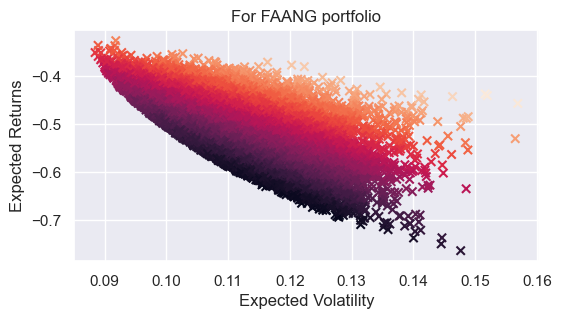

In [84]:
plt.figure(figsize=(6, 3))
plt.scatter(portfolio_std, portfolio_returns, c=s, marker='x')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.title('For FAANG portfolio')
plt.show()

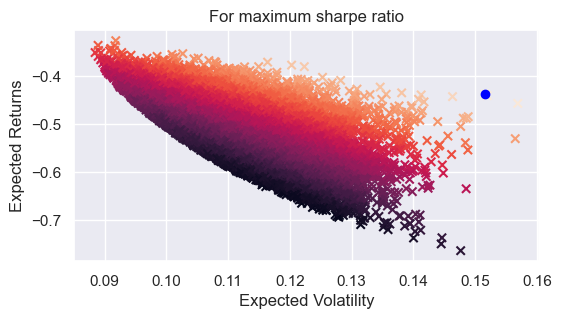

In [85]:
plt.figure(figsize=(6, 3))
plt.scatter(portfolio_std, portfolio_returns, c=s, marker='x')
plt.scatter(sharpe_max[0], sharpe_max[1], c='blue', marker='o')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.title('For maximum sharpe ratio')
plt.show()

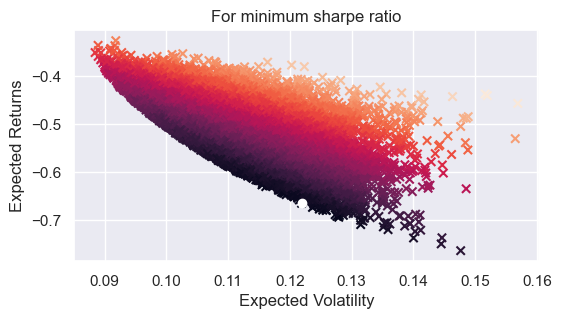

In [86]:
plt.figure(figsize=(6, 3))
plt.scatter(portfolio_std, portfolio_returns, c=s, marker='x')
plt.scatter(sharpe_min[0], sharpe_min[1], c='white', marker='o')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.title('For minimum sharpe ratio')
plt.show()

### Efficient Frontier

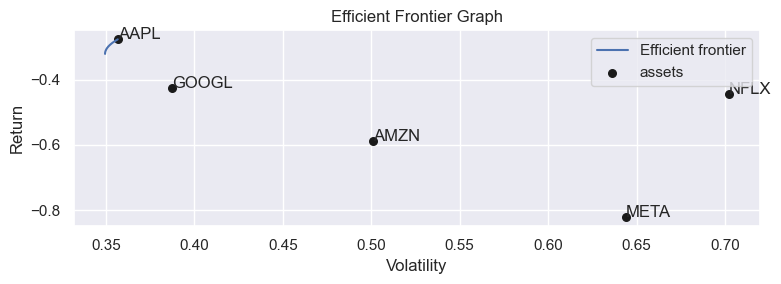

In [87]:
# Efficient Frontier Graph
plt.figure(figsize=(8, 3))
plt.title('Efficient Frontier Graph')
plotting.plot_efficient_frontier(EfficientFrontier(annualized_return, co_var), show_assets=True, show_tickers=True)
plt.show()

#### Interpretaion:
- It represents the optimal tradeoff between risk and return for a given set of assets or securities.
- The y-axis represents the expected return of the portfolio, while the x-axis represents the risk of the portfolio.
- Portfolios that lie on the efficient frontier are considered to be efficient portfolios because they provide the highest expected return for a given level of risk or the lowest level of risk for a given level of expected return.
- Portfolios that lie below the efficient frontier are considered to be suboptimal because they provide a lower expected return for a given level of risk.

---

# Time Series Modeling - FAANG stock price prediction

In [88]:
# Extracting Netflix data using yahoo finance for one year (2022)
stock = 'NFLX'
start = datetime.datetime(2022,1, 1)
end = datetime.datetime(2023,1, 1)
netflix_close = yf.download(stock, start=start, end=end, interval= '1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [89]:
# displaying top rows of the netfix
netflix_close.head()

Date
2022-01-03    597.369995
2022-01-04    591.150024
2022-01-05    567.520020
2022-01-06    553.289978
2022-01-07    541.059998
Name: Close, dtype: float64

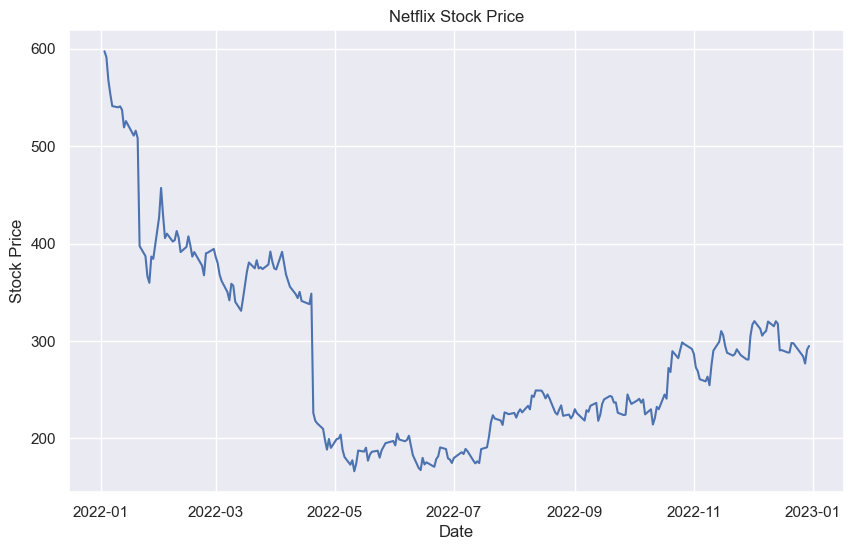

In [90]:
# Plotting the Stock price of Netflix

plt.figure(figsize=(10, 6))
plt.plot(netflix_close)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Netflix Stock Price')
plt.show()

### Time Series components: Trend, seasonality, cyclicality, and noise

Here is another important topic of time series. Before modeling a time series, we need to know the characteristics of it and time series components give us a invaluable clue about the characteristics of a time series. In Python, `seasonal_decompose` is the package that can be used in identifying the components.

#### model='multiplicative' (for seasonal decomposition)

\begin{equation} 
x_t = Trend * Seasonal * Random
\end{equation} 

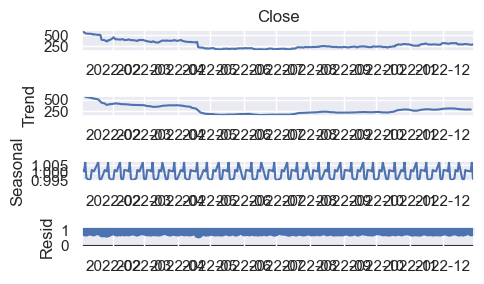

In [91]:
decomposition = seasonal_decompose(netflix_close, model='multiplicative', period=7)
decomposition.plot()
plt.show()

#### Interpretation:

In the first graph, we see the behavior of the raw data. Overall, it has a downward trend despite a small rise at the end quarter of 2022.

The second plot exhibits the `trend` of the data. Trend shows the overall movement of a time series. We can say that there exist a trend if there is a long-term increase or decrease in the data. So, we need to focus on the mean of the data at the beginning and end of the period to detect the trend. 

`Seasonality` is the third plot which shows periodical ups and downs in the data. If there is a seasonality in the data, it should also be removed. For instance, sales of a winter wear company goes down during summer and goes up during winter. It indicates quarterly seasonality. Seasonality might be weekly, monthly, quarterly, or yearly.

The last graph show the `residuals`. This is obtained after removing the trend and seasonal components from the time series. If we end up with a rather stable residual, it means that our data is stationary structure and ready to move on the modeling part. At first glance, the highly volatile distribution of the residual indicates that the data is not stationary.

Final time series component, which is not on the graph is `cyclicality`.  It exists when higher periodic variation than the trend emerges. We can, however, think of cyclicality as business cycles, which take a long time to complete their cycles and the ups and downs are over a long horizon. So cyclicality is different from seasonality in the sense that there is no fluctuation in a fixed period. 

In [92]:
# creating a dataframe for netflix_close 

netflix_close = pd.DataFrame(netflix_close)
netflix_close.isnull().sum()

Close    0
dtype: int64

#### Note:
There are no Missing values so we dont have to deal with the missing values time series.

fyi,
Missing Values can be handled by

* Forward Fill
* Backward Fill
* Interpolation

In [93]:
# displaying the last five rows data of the netflix_close dataframe

netflix_close.tail()

,Close
Date,
2022-12-23,294.959991
2022-12-27,284.170013
2022-12-28,276.880005
2022-12-29,291.119995
2022-12-30,294.880005


## Detecting and handling with stationarity

Stationary is a way to model the dependent structure that we have in time-dependent data. For instance, current stock price is somewhat related to the previous prices of the stock.

In [94]:
netflix_close

,Close
Date,
2022-01-03,597.369995
2022-01-04,591.150024
2022-01-05,567.520020
2022-01-06,553.289978
2022-01-07,541.059998
...,...
2022-12-23,294.959991
2022-12-27,284.170013
2022-12-28,276.880005


In [95]:
netflix_diff =netflix_close.diff().dropna()

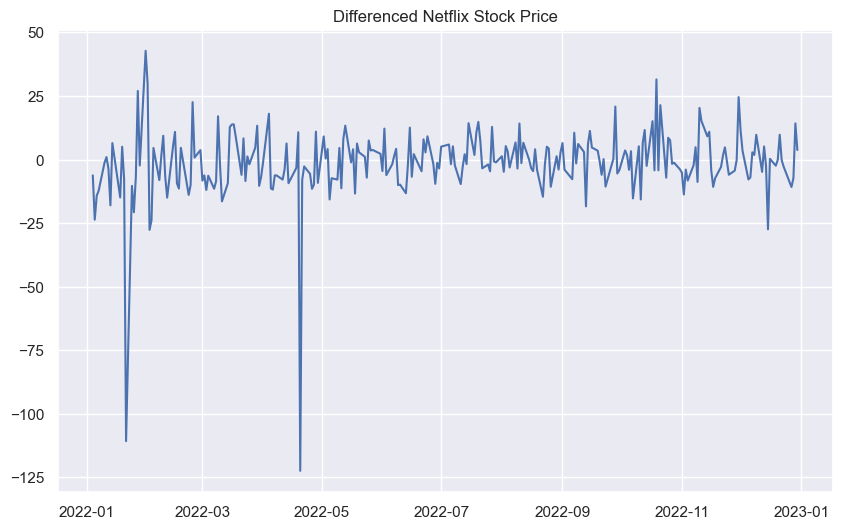

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(netflix_diff)
plt.title('Differenced Netflix Stock Price')
plt.show()

## Statistical Test for detecting stationarity: ADF

Statistical tests provide us a robust method to detect stationarity. In this part of the class, we will talk about a statistical method in detecting the stationarity: Augmented Dickey Fuller (`ADF`)

In [97]:
from statsmodels.tsa.stattools import adfuller
stat_test = adfuller(netflix_close)
print('The test statistics is {} and p-value is {}'.format(stat_test[0], stat_test[1]))

The test statistics is -3.5600206562456016 and p-value is 0.006572986401589552


#### Interpretation:
p-value , It suggests that the time series is stationary as it is lower than 0.05. So, what is no need to find a way to make the data stationary.

## ACF and PACF

#### ACF :

Autocorrelation is the correlation of the same variable at different times, say $X_t$ and $X_{t+k}$.
Thus, autocorrelation is a correlation coefficient.
Autocorrelation implies serial dependence. Precisely, it occurs when a time series is highly correlated with its lagged version. It is shown by acf plot. The longer of the bar in the acf plot, the more dependence a series has.

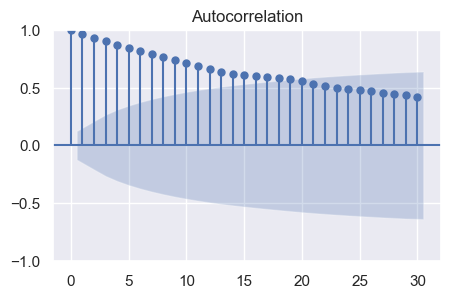

In [98]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(netflix_close, lags = 30);

#### Interpretation: 
The `acf` plot indicates that acf is slowly decaying, which is an indicator of non-stationarity. Besides, the blue shaded area represents the confidence interval. If the bar is in this confidence interval, it indicates that there is no significant correlation between this lag and the current one and this information is used for identifying the optimal lag. As this data is non-stationary, it makes no sense to apply this information here.

when the first difference of the stock price is taken. `.diff()` function takes the first difference in Python.

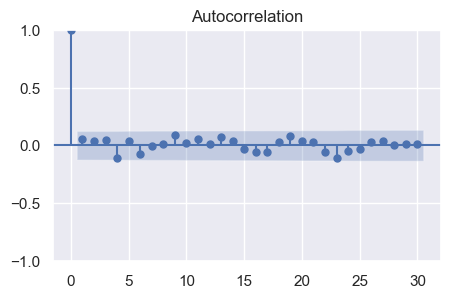

In [99]:
sm.graphics.tsa.plot_acf(netflix_diff, lags = 30);


The above-given acf plot exhibits that there is a spike at the $9^{th}$, $11^{th}$ and $13^{th}$ lags. Larger lags works better. Here, I pick $13^{th}$ lag.

#### Note:
In moving average, acf is used for this Project. As for the Autoregressive Integrated model Average, pacf is the tool used.

#### PACF 
Partial Autocorrelation Function (PACF) is another method to examine the relationship between ${X_t}$ and ${X_{t-p}}, p\in \mathbb{Z}$.
PACF provides information on correlation between current value of a time series and its lagged values controlling for the other correlations.

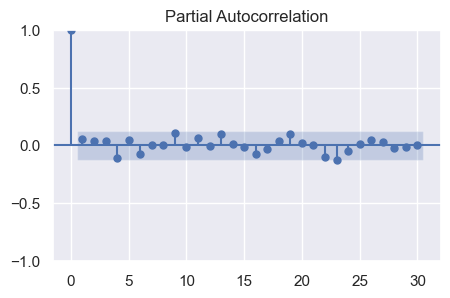

In [100]:
sm.graphics.tsa.plot_pacf(netflix_diff, lags = 30);

#### Note:

The result that we get from pacf is similar to what we have in acf. So, pick $13^{th}$ lag. We are going to use this lag structure in our time series model.

# Time Series Models

* Moving Average Model
* Autoregressive Integrated Moving Average Model

# Moving Average Model

`Moving average`model tries to capture the time series dynamics simply by error terms. Let $e_t$ is a normally distributed term, meaning that it is identically and independently distributed (iid). So, unlike AR, MA is alway stationary.

#### calculate the first difference and drop the missing values to not to get `exog contains inf or nans` error.

In [101]:
diff_netflix = netflix_close.diff().dropna()

In [102]:
diff_netflix

,Close
Date,
2022-01-04,-6.219971
2022-01-05,-23.630005
2022-01-06,-14.230042
2022-01-07,-12.229980
2022-01-10,-1.210022
...,...
2022-12-23,-2.790009
2022-12-27,-10.789978
2022-12-28,-7.290009


### Splitting the data into train and test data for time series modeling

In [103]:
diff_train_len = int(len(diff_netflix)*0.80)
diff_train = diff_netflix[:diff_train_len]
diff_test = diff_netflix[diff_train_len:]

In [104]:
start = len(diff_train)
end = len(diff_train) + len(diff_test) - 1

In [105]:
ma_model = ARIMA(diff_train, order =(0,0,13))
ma_result = ma_model.fit()

In [106]:
ma_pred = ma_result.predict(start, end)
ma_pred.index = diff_test.index

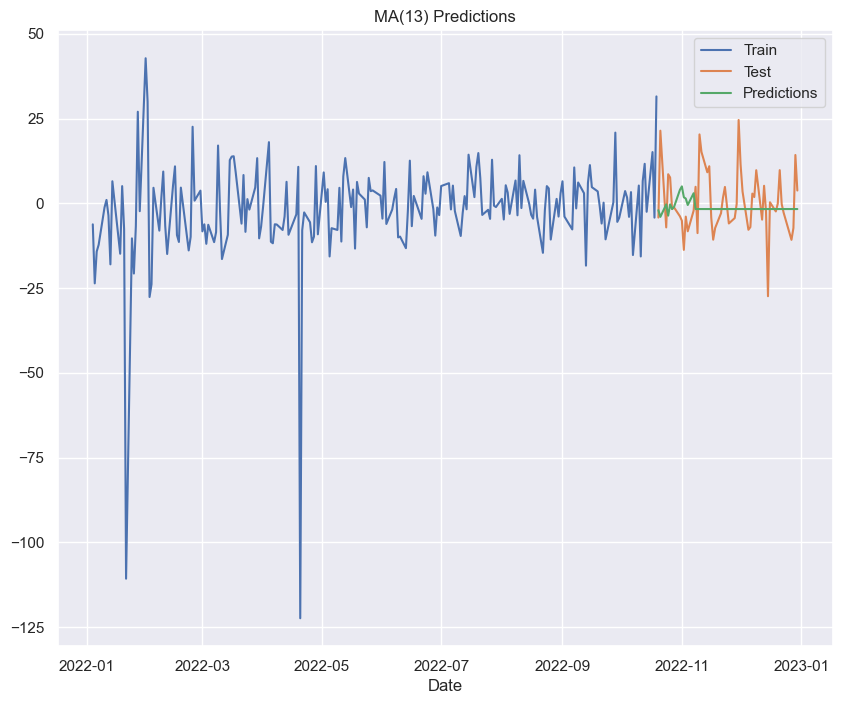

In [107]:
plt.figure(figsize=(10, 8))
plt.title('MA(13) Predictions')
plt.plot(diff_train, label='Train')
plt.plot(diff_test, label='Test')
plt.plot(ma_pred, label='Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [108]:
mae_ma = mean_absolute_error(diff_test, ma_pred)
mse_ma = mean_squared_error(diff_test, ma_pred)
rmse_ma = np.sqrt(mean_squared_error(diff_test, ma_pred))

In [109]:
ma_perf = {'mae_ma': mae_ma, 'mse_ma': mse_ma,
'rmse_ma': rmse_ma}
ma_perf = pd.DataFrame([ma_perf])
ma_perf

,mae_ma,mse_ma,rmse_ma
0,7.709611,102.969778,10.147403


In [110]:
forecast_index = pd.date_range(diff_test.index[-1], periods=10)

In [111]:
ma_model = ARIMA(diff_netflix, order =(0,0,13))
ma_result = ma_model.fit()
ma_forecast = ma_result.forecast(steps=10)
ma_forecast.index = forecast_index

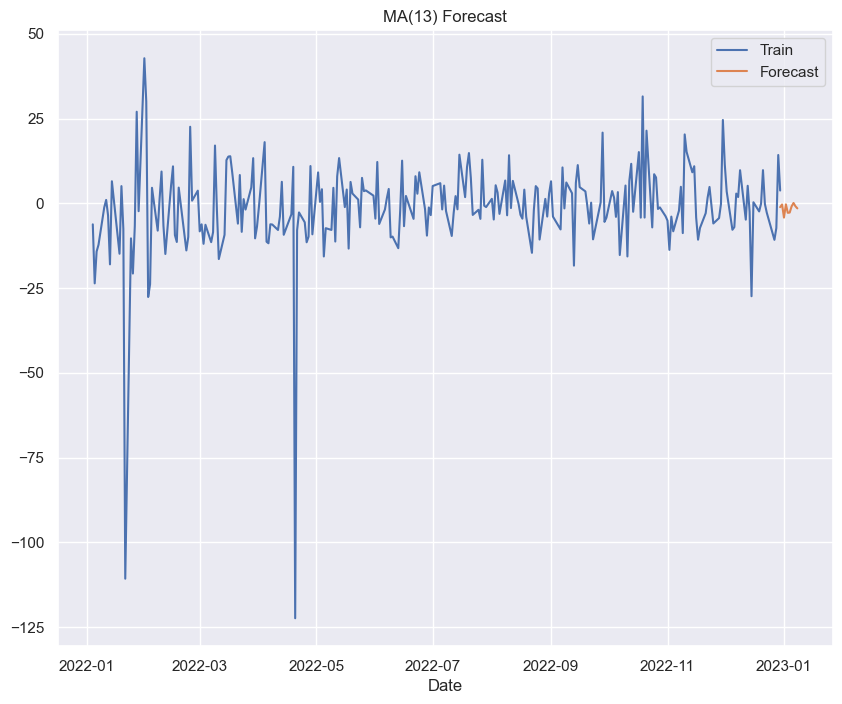

In [112]:
plt.figure(figsize=(10, 8))
plt.title('MA(13) Forecast')
plt.plot(diff_netflix, label='Train')
plt.plot(ma_forecast, label='Forecast')
plt.xlabel('Date')
plt.legend()
plt.show()

# Autoregressive Integrated Moving Average Model

ARIMA(p,d,q) has three parameters and one of is for making a series stationary.

In [113]:
train_len = int(len(netflix_close)*0.8)
train = netflix_close[:train_len]
test = netflix_close[train_len:]

In [114]:
arima_model = ARIMA(train, order = (13, 1, 13))#p, d, q
arima_result = arima_model.fit()

In [115]:
arima_pred = arima_result.predict(start, end)
arima_pred.index = diff_test.index

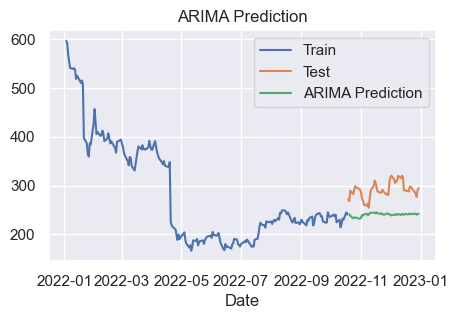

In [116]:
#plt.figure(figsize=(10, 6 ))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(arima_pred, label='ARIMA Prediction')
plt.title('ARIMA Prediction')
plt.legend()
plt.xlabel('Date');

In [117]:
arima_pred_diff = arima_pred.diff().dropna()

In [118]:
mae_arima = mean_absolute_error(diff_test.iloc[1:], arima_pred_diff)
mse_arima = mean_squared_error(diff_test.iloc[1:], arima_pred_diff)
rmse_arima = np.sqrt(mean_squared_error(diff_test.iloc[1:], arima_pred_diff))

In [119]:
arima_perf = {'mae_arima':mae_arima, 'mse_arima':mse_arima,
'rmse_arima':rmse_arima} 
arima_perf = pd.DataFrame([arima_perf])
arima_perf

,mae_arima,mse_arima,rmse_arima
0,7.310543,95.882959,9.791984


In [120]:
arima_model = ARIMA(netflix_close, order=(13, 1, 13))
arima_result = arima_model.fit()

In [121]:
arima_forecast = arima_result.forecast(steps=10)
arima_forecast.index = forecast_index

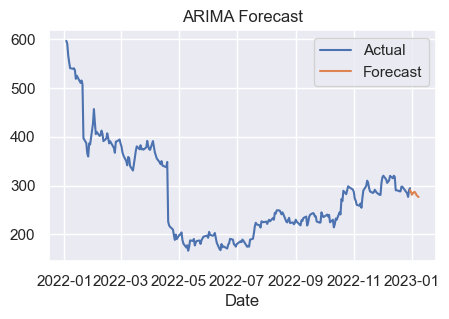

In [122]:
plt.plot(netflix_close, label='Actual')
plt.plot(arima_forecast, label='Forecast')
plt.title('ARIMA Forecast')
plt.legend()
plt.xlabel('Date');

## Interpretation

#### Moving Average Model:

The moving Average Model is forecasting that the stock price can be downward and can go down in the near term.

#### Autoregressive Integrated Moving Average Model

ARIMA model is forecasting that the price of Netflix stock can go down in the near term.

In Summary both of the models are forecasting the same that the stock price of the Netflix trend is downward.


### Conclusion
Based on the metrics, it appears that the ARIMA model (with MAE of 7.32563, MSE of 95.939804, and RMSE of 9.794887) performs better than the MA model (with MAE of 7.709611, MSE of 102.969777, and RMSE of 10.147402).